<a href="https://colab.research.google.com/github/JankaUhrinova/Assessing-Unsupervised-Pretraining-for-improving-prediction-in-Digital-Pathology/blob/main/ConvNet_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [3]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12



In [4]:
train_set = datasets.MNIST(
    root = './data/MNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

test_set = datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
print(train_set, test_set)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/MNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [5]:
class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        #self.conv0_bn = nn.BatchNorm2d(32)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        #self.conv1_bn = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        #self.conv2_bn = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        #self.conv3_bn = nn.BatchNorm2d(256)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(12544, 10)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2)
        #x = self.conv0_bn(x)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        #x = self.conv1_bn(x)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        #x = self.conv2_bn(x)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        #x = self.conv3_bn(x)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        
        return x
    
    def num_flat_features(self, x):
        return np.prod(x.shape[1:])

In [6]:
import collections

# convolutional model
model_conv = nn.Sequential(collections.OrderedDict([
        # fill in structure 
          ('conv1', nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)),
          ('relu1', nn.ReLU()),
          ('dropout', nn.Dropout2d(0.25)),
          ('conv2', nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)),
          ('relu2', nn.ReLU()),
          ('dropout', nn.Dropout2d(0.25)),
          ('conv3', nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)),
          ('relu3', nn.ReLU()),
          ('dropout', nn.Dropout2d(0.25)),
          ('conv4', nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)),
          ('relu4', nn.ReLU()),
          ('dropout', nn.Dropout2d(0.25)),
          ('reshape', nn.Flatten()),
          ('lin', nn.Linear(12544,10)),
          ('softmax', nn.Softmax())
        ]))

In [7]:
import datetime
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))

def test_loop(model, device, loss_fn, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [8]:
model = ConvNet()
print(model)
model = model.to(device)
model = model.float()

ConvNet(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv0_drop): Dropout2d(p=0.25, inplace=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_drop): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_drop): Dropout2d(p=0.25, inplace=False)
  (fc): Linear(in_features=12544, out_features=10, bias=True)
)


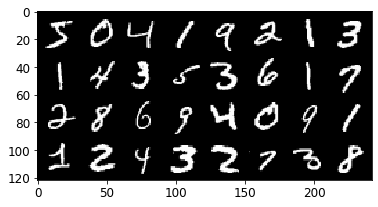

In [11]:
# set up a loader object to use minibatches
loader = torch.utils.data.DataLoader(train_set, batch_size = 32)
# also set up a loader for test data, using a single batch
test_loader = torch.utils.data.DataLoader(test_set)

# we set the optimiser as Stochastic Gradient Descent for both networks, 
# you could also try Adam
optimizer_conv = optim.SGD(model.parameters(), lr=0.01)

# show the first batch of training data (you don't need to understand this code)
images, labels = next(iter(loader))
grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')


# set the loss function to optimise. Cross Entropy is usually the best for 
# classification
loss_fn = nn.CrossEntropyLoss()

In [12]:
n_epochs = 5 # see how sensitive results are to this

# train the CNN
training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer_conv,
    model = model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = loader,
)

2023-02-23 18:00:54.100859 Epoch 1, Training loss 1498.7883863300085
2023-02-23 18:01:07.072361 Epoch 2, Training loss 409.67582774627954
2023-02-23 18:01:19.817704 Epoch 3, Training loss 268.5182527080178
2023-02-23 18:01:33.141757 Epoch 4, Training loss 213.71915812033694
2023-02-23 18:01:46.204487 Epoch 5, Training loss 184.0104831259814
